# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
import keras
import keras_tuner as kt
import xgboost as xgb

from random import gauss
from random import seed

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error,r2_score

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from pmdarima import auto_arima
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
from keras.models import load_model,Sequential

In [3]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head()

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.23,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.69,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.23,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.06,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.64,88.76,168.17,268.37


In [4]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [5]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [6]:
df.columns

Index(['nonglu_price', 'hommali_price', 'agri_prod_index', 'crops_prod_index',
       'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index',
       'nonglu_price_index', 'hommali_price_index', 'agri_export_value',
       'rice_export_value', 'ricet_export_amount', 'cpi', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6', 'water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'water_

In [7]:
df.shape

(226, 49)

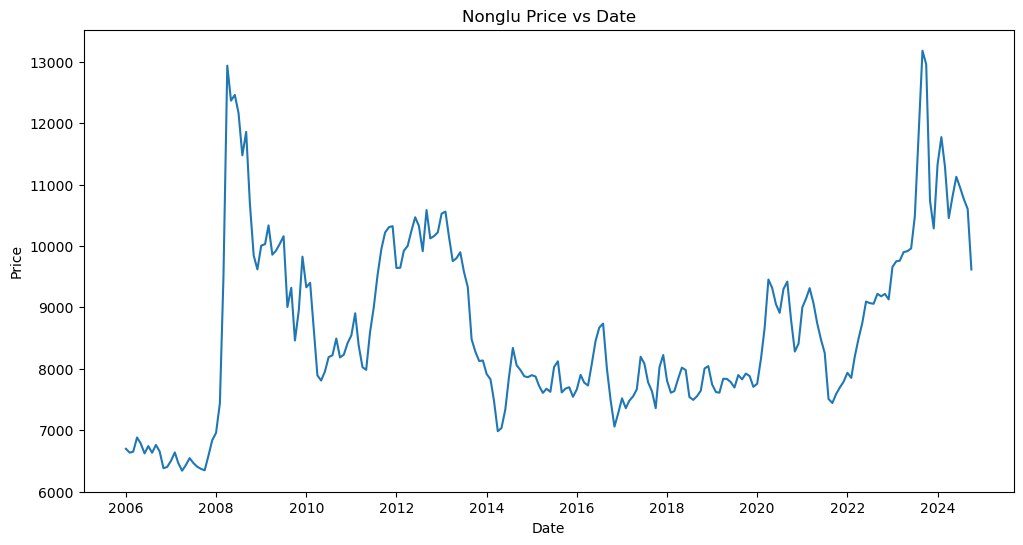

In [8]:
#plot the "nonglu_price" column vs date to see the trend
plt.figure(figsize=(12,6))
plt.plot(df['nonglu_price'])
plt.title('Nonglu Price vs Date')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

# Stationarity Check

In [10]:
result = adfuller(df['nonglu_price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -3.302824716654775
p-value: 0.014752680770463844
Critical Values:
   1%: -3.4604283689894815
   5%: -2.874768966942149
   10%: -2.57382076446281


In [11]:
# ADF Statistic = -3.303
# A highly negative value generally indicates evidence against the null hypothesis 
# (non-stationarity). However, the magnitude alone is not the only determinant; 
# the test's critical values must also be considered for confirmation.

# More negative than both the 5% (-2.875) and 10% (-2.574) critical values
# But not more negative than the 1% critical value (-3.460)
# This means one can reject the null hypothesis of non-stationarity at the 5% confidence level 
# (which we're using down below) but not at the 1% level (which is basically fine here)
# The p-value of 0.015 confirms this, as it's less than 0.05 but greater than 0.01

# p-value = 0.015
# This is less than the standard 0.05 significance level
# Therefore, we reject the null hypothesis of non-stationarity
# This output justifies rejecting the null hypothesis that the series is non-stationary.

# Adds some features

In [13]:
import warnings
warnings.filterwarnings("ignore")

# Calculate ratio between current price and 6-month moving average to possibly detect unusual acceleration
# Likely the most viable and valuable of the options listed
df['price_vs_6ma'] = df['nonglu_price'] / df['nonglu_price'].rolling(6).mean()

# Add lagged fertilizer prices to possibly catch early price pressure signals
# Might be noisy due to long lead time - could be adjusted?
df['fert1_lag6m'] = df['fertilizer_1'].shift(6)

# Calculate month-over-month percent changes for grain prices to possibly capture rapid market shifts
# Could be quite noisy and act more as a lagging indicator than a leading indicator
df['nonglu_mom'] = df['nonglu_price'].pct_change()
df['hommali_mom'] = df['hommali_price'].pct_change() 
df['paddy_mom'] = df['paddy_price_index'].pct_change()

# Impute NaN 
df['price_vs_6ma'].fillna(df['price_vs_6ma'].iloc[7],inplace=True)
df['fert1_lag6m'].fillna(df['fert1_lag6m'].iloc[7],inplace=True)
df['nonglu_mom'].fillna(df['nonglu_mom'].iloc[1],inplace=True)
df['hommali_mom'].fillna(df['hommali_mom'].iloc[1],inplace=True)
df['paddy_mom'].fillna(df['paddy_mom'].iloc[1],inplace=True)

# Calculate Ratio of Paddy Price Index 
df['nonglu_vs_total'] = df['nonglu_price_index']/ df['paddy_price_index']

# Model

In [15]:
# Create the target
y = df['nonglu_price']

# Define independent variables (predictors) X
xvars = ['hommali_price','agri_price_index', 'crops_price_index','hommali_price_index',
         'agri_prod_index', 'crops_prod_index','paddy_prod_index', 
         'nonglu_prod_index', 'hommali_prod_index',
         'agri_export_value', 'ricet_export_amount', 'cpi',
         'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
         'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4','fertilizer_5', 'fertilizer_6',
         'water_station_B10', 
         'water_station_C13', 'water_station_C2', 'water_station_G8',
         'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
         'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
         'water_station_M6A', 'water_station_M7', 'water_station_N1',
         'water_station_N67', 'water_station_Ny1B', 
         'water_station_P1','water_station_P17',
         'water_station_S4B', 'water_station_Sw5A',
         'water_station_Y17', 'water_station_Y1C',
         'price_vs_6ma', 'fert1_lag6m','nonglu_mom', 'hommali_mom', 'paddy_mom','nonglu_vs_total']


# Adjust X to match the same periods
X = df[xvars]

In [16]:
# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 50), (25, 50), (201,), (25,))

In [17]:
X_train['shock_event'] = [1 if date >= pd.to_datetime('2023-12-01') else 0 for date in y_train.index]
X_test['shock_event'] = [1 if date >= pd.to_datetime('2023-12-01')  else 0 for date in y_test.index]

# If the sharp drop can be explained through existing exogenous variables or lagged 
# effects, a shock variable may not add significant predictive value.
# If the drop reflects a unique, external event, the shock variable might be the key 
# to improving forecasts.

## 1. Linear Regression Model

### Model 1: Linear Regression Model

In [20]:
label = 'nonglu_price'
df = df[xvars + [label]]

train_data = df[df.index < '2023-01-01']
test_data = df[df.index >= '2023-01-01']

X_train = train_data.drop(columns=['nonglu_price'])
y_train = train_data['nonglu_price']

X_test = test_data.drop(columns=['nonglu_price'])
y_test = test_data['nonglu_price']

In [21]:
# Instantiate and fit an Linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((204, 50), (22, 50), (204,), (22,))

In [23]:
# Prediction
y_pred = lr.predict(X_test)

In [24]:
# Evaluate the Linear Regression Model
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = root_mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)
print(f"Linear Regression Model MSE: {lr_mse:.4f}")
print(f"Linear Regression Model RMSE: {lr_rmse:.4f}")
print(f"Linear Regression Model R-squared: {lr_r2:.4f}")

Linear Regression Model MSE: 640321.4744
Linear Regression Model RMSE: 800.2009
Linear Regression Model R-squared: 0.3197


In [25]:
# Create Accuracy Dataframe
lr_accuracy = pd.DataFrame(data = {'model': ['Linear'] * 3,
                                   'accuracy':['MSE','RMSE','R2'],'score':[lr_mse,lr_rmse,lr_r2]})
lr_accuracy

,model,accuracy,score
0,Linear,MSE,640321.474424
1,Linear,RMSE,800.200896
2,Linear,R2,0.319708


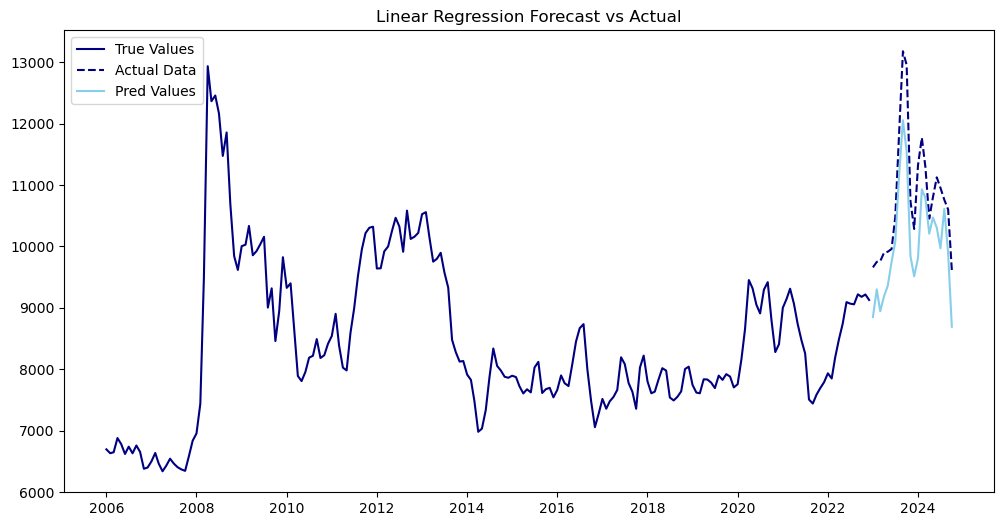

<Figure size 640x480 with 0 Axes>

In [26]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(test_data.index,y_pred, c='skyblue', label='Pred Values')
plt.title("Linear Regression Forecast vs Actual")
plt.legend()
plt.show()
# saving the plot as an image
plt.savefig('../figure/Linear Regression Forecast vs Actual.png')
plt.show()

#### Feature importance

In [28]:
#print regression coefficients
pd.DataFrame(zip(X.columns, lr.coef_))

,0,1
0,hommali_price,6.244000e+08
1,agri_price_index,-4.802395e+01
2,crops_price_index,4.821714e+01
3,hommali_price_index,-4.797993e+10
4,agri_prod_index,3.073047e+01
5,crops_prod_index,-2.104995e+01
6,paddy_prod_index,-2.271559e-01
7,nonglu_prod_index,-3.938149e-01
8,hommali_prod_index,-2.084891e-01
9,agri_export_value,2.331665e-01


## 2. ARIMA Model

### Model 2 : ARIMA

In [31]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax1_model = ARIMA(
    y_train,                 # Dependent variable (nonglu_price)
    exog=X_train,            # External variables 
    order=(2, 1, 2)).fit()   # ARIMA parameters: (p=2, d=1, q=2)

In [32]:
# Generate predictions on the test set
arimax1_forecast = arimax1_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [33]:
# Evaluate the ARIMAX(2,1,2) Model
arimax1_mse = mean_squared_error(y_test, arimax1_forecast)
arimax1_rmse = root_mean_squared_error(y_test, arimax1_forecast)
arimax1_r2 = r2_score(y_test, arimax1_forecast)
print(f"ARIMAX(2,1,2) Model MSE : {arimax1_mse:.4f}")
print(f"ARIMAX(2,1,2) Model RMSE :{arimax1_rmse:.4f}")
print(f"ARIMAX(2,1,2) Model R-squared :{arimax1_r2:.4f}")

ARIMAX(2,1,2) Model MSE : 1508931.0874
ARIMAX(2,1,2) Model RMSE :1228.3856
ARIMAX(2,1,2) Model R-squared :-0.6031


In [34]:
# Create Accuracy Dataframe
arimax1_accuracy = pd.DataFrame(data = {'model': ['ARIMAX(2,1,2)'] * 3,
                                'accuracy':['MSE','RMSE','R2'],'score':[arimax1_mse,arimax1_rmse,arimax1_r2]})
arimax1_accuracy

,model,accuracy,score
0,"ARIMAX(2,1,2)",MSE,1.508931e+06
1,"ARIMAX(2,1,2)",RMSE,1.228386e+03
2,"ARIMAX(2,1,2)",R2,-6.031222e-01


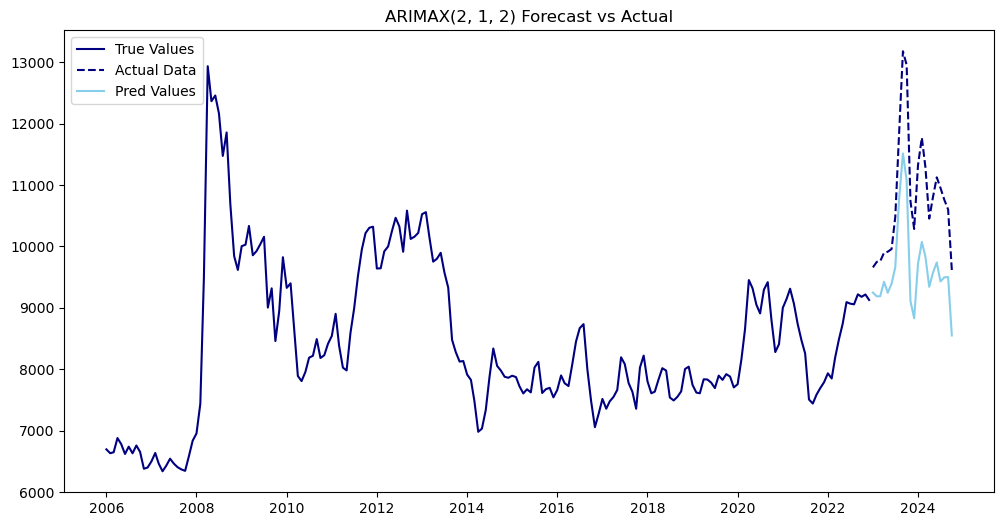

In [35]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax1_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2, 1, 2) Forecast vs Actual")
plt.legend()
# saving the plot as an image
plt.savefig('../figure/ARIMAX(2,1,2) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [37]:
arimax1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  204
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1233.558
Date:                Wed, 18 Dec 2024   AIC                           2577.116
Time:                        12:05:46   BIC                           2759.342
Sample:                    01-01-2006   HQIC                          2650.837
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
hommali_price           0.3495      0.034     10.172      0.000       0.282       0.417
agri_price_index       -3.9792     18.008     -0.221      0.825     -39.273      31.315
crops_price_index       5.2256     13.384      0.390      0.696     -21.007      31.459
hommali_price_index     0.0045        nan        nan        nan         nan         nan
agri_prod_index         2.5338      5.682      0.446      0.656      -8.602      13.670
crops_prod_index       -1.3613      4.205     -0.324      0.746      -9.604       6.881
paddy_prod_index        0.0506      1.032      0.049      0.961      -1.972       2.073
nonglu_prod_index      -0.1483      0.699     -0.212      0.832      -1.517       1.221
hommali_prod_index     -0.1163      0.397     -0.293      0.769      -0.894       0.661
agri_export_value       0.1172      0.086      1.360      0.174      -0.052       0.286
ricet_export_amount -9.195e-05   8.18e-05     -1.124      0.261      -0.000    6.84e-05
cpi                    -2.9269     43.605     -0.067      0.946     -88.391      82.538
pol_rate               -4.3372     98.915     -0.044      0.965    -198.207     189.533
neer                  -35.4618     44.911     -0.790      0.430    -123.487      52.563
reer                   43.7993     44.072      0.994      0.320     -42.580     130.179
sirikit_water          -0.1284      0.164     -0.784      0.433      -0.449       0.193
bhumibol_water          0.0025      0.053      0.048      0.962      -0.101       0.106
fertilizer_1           -0.0831      0.028     -3.010      0.003      -0.137      -0.029
fertilizer_2            0.0060      0.021      0.286      0.775      -0.035       0.047
fertilizer_3            0.0678      0.028      2.440      0.015       0.013       0.122
fertilizer_4           -0.0065      0.012     -0.556      0.578      -0.029       0.016
fertilizer_5            0.0363      0.028      1.288      0.198      -0.019       0.092
fertilizer_6           -0.0354      0.018     -2.016      0.044      -0.070      -0.001
water_station_B10       0.0500      0.335      0.149      0.881      -0.607       0.707
water_station_C13      -0.0156      0.035     -0.449      0.653      -0.084       0.052
water_station_C2        0.0038      0.056      0.067      0.946      -0.106       0.113
water_station_G8       -0.4876      0.521     -0.936      0.349      -1.509       0.533
water_station_K10      -0.0506      0.081     -0.624      0.533      -0.210       0.108
water_station_K11A     -0.0611      0.059     -1.041      0.298      -0.176       0.054
water_station_Kgt3      0.0795      0.060      1.317      0.188      -0.039       0.198
water_station_Kh103     0.4291      0.787      0.545      0.585      -1.113       1.971
water_station_Kh58A    -0.1332      0.166     -0.802      0.423      -0.459       0.192
water_station_Kh72      1.0713      1.022      1.048      0.295      -0.932       3.075
water_station_M6A       0.0185      0.039      0.470      0.638      -0.0

### Model 3 : Auto ARIMA

In [39]:
# Automatically tune ARIMA parameters
auto_model = auto_arima(
    y_train,exogenous=X_train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,seasonal=False, trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)

# Best parameters
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1518.392
Date:                Wed, 18 Dec 2024   AIC                           3044.784
Time:                        12:05:46   BIC                           3058.057
Sample:                    01-01-2006   HQIC                          3050.153
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    675.3785    215.699      3.131      0.002     252.615    1098.142
ar.L1          1.2124      0.030     40.094      0.000       1.153       1.272
ar.L2         -0.2929      0.037     -7.909      0.0

In [40]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax2_model = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog = X_train,    # External variables 
    order = (2, 0, 0), # ARIMA parameters: (p=2, d=0, q=0)
).fit()

# Get the residual
arimax2_model_residuals = arimax2_model.resid

# Generate predictions on the test set
arimax2_forecast = arimax2_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [41]:
# Evaluate the ARIMAX(2,0,0) Model
arimax2_mse = mean_squared_error(y_test, arimax2_forecast)
arimax2_rmse = root_mean_squared_error(y_test, arimax2_forecast)
arimax2_r2 = r2_score(y_test, arimax2_forecast)
print(f"ARIMAX(2,0,0) Model MSE : {arimax2_mse:.4f}")
print(f"ARIMAX(2,0,0) Model RMSE :{arimax2_rmse:.4f}")
print(f"ARIMAX(2,0,0) Model R-squared :{arimax2_r2:.4f}")

ARIMAX(2,0,0) Model MSE : 724617.8282
ARIMAX(2,0,0) Model RMSE :851.2449
ARIMAX(2,0,0) Model R-squared :0.2301


In [42]:
# Create Accuracy Dataframe
arimax2_accuracy = pd.DataFrame(data = {'model': ['ARIMAX(2,0,0)'] * 3,
                                'accuracy':['MSE','RMSE','R2'],'score':[arimax2_mse,arimax2_rmse,arimax2_r2]})
arimax2_accuracy

,model,accuracy,score
0,"ARIMAX(2,0,0)",MSE,724617.828239
1,"ARIMAX(2,0,0)",RMSE,851.244870
2,"ARIMAX(2,0,0)",R2,0.230150


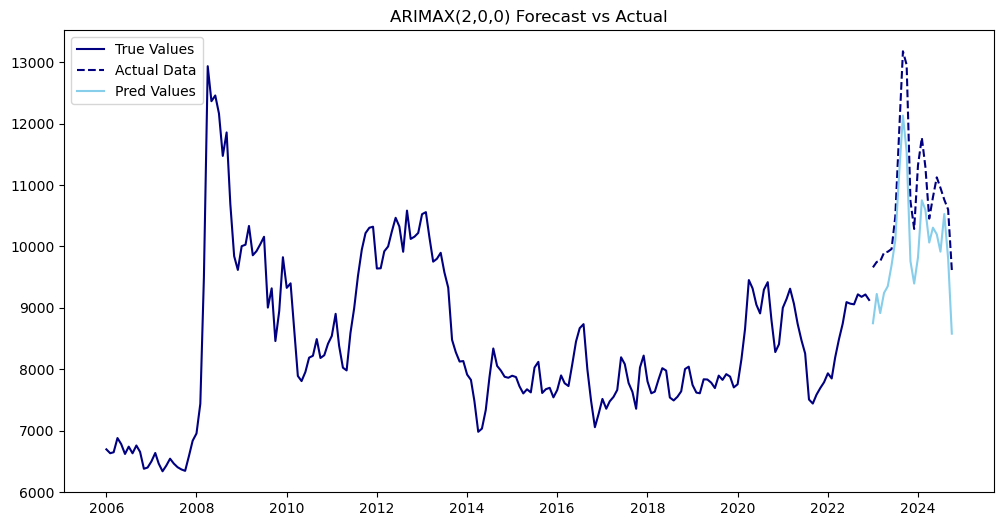

<Figure size 640x480 with 0 Axes>

In [43]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax2_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2,0,0) Forecast vs Actual")
plt.legend()
plt.show()
# saving the plot as an image
plt.savefig('../figure/ARIMAX(2,0,0) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [45]:
arimax2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  204
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1374.460
Date:                Wed, 18 Dec 2024   AIC                           2856.919
Time:                        12:05:57   BIC                           3036.098
Sample:                    01-01-2006   HQIC                          2929.400
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.125e+04    270.026    -41.651      0.000   -1.18e+04   -1.07e+04
hommali_price           0.2714      0.033      8.347      0.000       0.208       0.335
agri_price_index      -48.0227     20.819     -2.307      0.021     -88.827      -7.219
crops_price_index      48.2149     15.826      3.047      0.002      17.197      79.233
hommali_price_index     0.0035        nan        nan        nan         nan         nan
agri_prod_index        30.7323     13.210      2.326      0.020       4.840      56.624
crops_prod_index      -21.0537      9.327     -2.257      0.024     -39.334      -2.774
paddy_prod_index       -0.2296      3.329     -0.069      0.945      -6.755       6.296
nonglu_prod_index      -0.3940      1.988     -0.198      0.843      -4.290       3.502
hommali_prod_index     -0.2157      1.267     -0.170      0.865      -2.698       2.267
agri_export_value       0.2330      0.165      1.414      0.157      -0.090       0.556
ricet_export_amount    -0.0007      0.000     -3.353      0.001      -0.001      -0.000
cpi                    -1.2057     18.260     -0.066      0.947     -36.996      34.584
pol_rate              -20.3371     81.946     -0.248      0.804    -180.949     140.275
neer                  -43.3873     19.664     -2.206      0.027     -81.928      -4.846
reer                   53.5224     21.787      2.457      0.014      10.821      96.224
sirikit_water           0.1320      0.567      0.233      0.816      -0.979       1.244
bhumibol_water         -0.0367      0.191     -0.193      0.847      -0.411       0.337
fertilizer_1           -0.0403      0.058     -0.697      0.486      -0.154       0.073
fertilizer_2           -0.0392      0.032     -1.242      0.214      -0.101       0.023
fertilizer_3            0.1162      0.058      1.996      0.046       0.002       0.230
fertilizer_4            0.0884      0.040      2.194      0.028       0.009       0.167
fertilizer_5           -0.0429      0.078     -0.547      0.584      -0.197       0.111
fertilizer_6           -0.0340      0.061     -0.556      0.578      -0.154       0.086
water_station_B10      -0.7975      1.045     -0.763      0.445      -2.846       1.251
water_station_C13       0.2612      0.092      2.828      0.005       0.080       0.442
water_station_C2       -0.3099      0.148     -2.093      0.036      -0.600      -0.020
water_station_G8       -0.1445      1.649     -0.088      0.930      -3.377       3.088
water_station_K10      -0.0744      0.188     -0.395      0.693      -0.443       0.295
water_station_K11A     -0.1912      0.176     -1.089      0.276      -0.535       0.153
water_station_Kgt3      0.3216      0.240      1.340      0.180      -0.149       0.792
water_station_Kh103    -0.9511      2.614     -0.364      0.716      -6.075       4.173
water_station_Kh58A     0.0243      0.701      0.035      0.972      -1.349       1.398
water_station_Kh72     -1.6196      2.870     -0.564      0.573      -7.2

## 4. GARCH Model

### Model 4 : GARCH

In [48]:
# Seed pseudorandom number generator
seed(1)

# Define model - fit on the residuals.
garch_model = arch_model(arimax2_model_residuals,mean='HARX', vol='GARCH', p=1, q=1, rescale=False)

# Fit model
garch_model_fit = garch_model.fit(disp='off')

# forecast the test set
garch_forecast = garch_model_fit.forecast(horizon=len(y_test), reindex=False)
garch_volatility = np.sqrt(garch_forecast.variance.values[-1])  # Convert to standard deviation

arimax_forecast = arimax2_model.get_forecast(steps=len(y_test), exog=X_test)
arimax_mean = arimax_forecast.predicted_mean

# combine ARIMAX Mean and GARCH Volatility
yhat = arimax_mean + garch_volatility  # Add GARCH volatility directly

In [49]:
# Evaluate the GARCH Model
garch_mse = mean_squared_error(y_test, yhat)
garch_rmse = root_mean_squared_error(y_test, yhat)
garch_r2 = r2_score(y_test, yhat)
print(f"GARCH Model MSE : {garch_mse:.4f}")
print(f"GARCH Model RMSE :{garch_rmse:.4f}")
print(f"GARCH Model R-squared :{garch_r2:.4f}")

GARCH Model MSE : 448607.7417
GARCH Model RMSE :669.7819
GARCH Model R-squared :0.5234


In [50]:
# Create Accuracy Dataframe
garch_accuracy = pd.DataFrame(data = {'model': ['GARCH '] * 3,
                                'accuracy':['MSE','RMSE','R2'],'score':[garch_mse,garch_rmse,garch_r2]})
garch_accuracy

,model,accuracy,score
0,GARCH,MSE,448607.741743
1,GARCH,RMSE,669.781861
2,GARCH,R2,0.523389


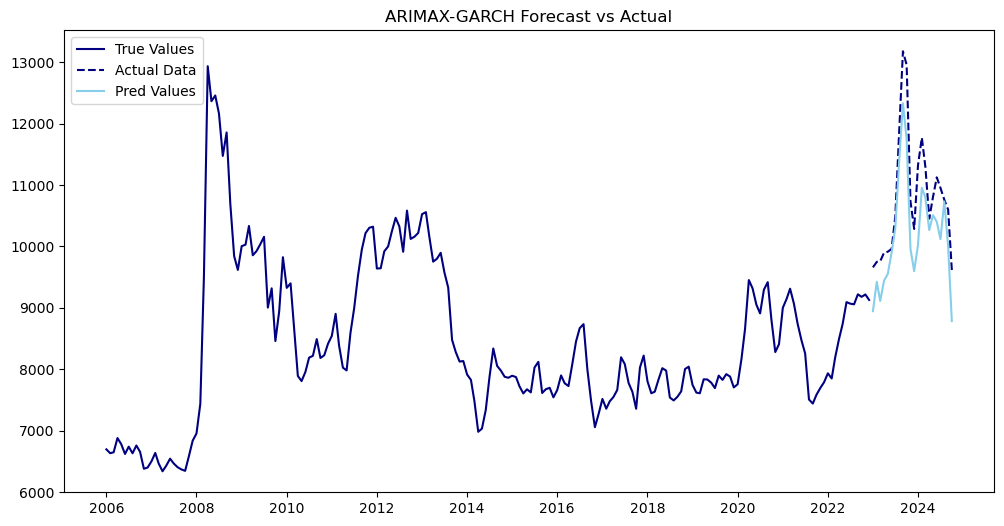

<Figure size 640x480 with 0 Axes>

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label="True Values")
plt.plot(y_test.index, y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(y_test.index, yhat, c='skyblue', label="Pred Values")
plt.legend()
plt.title("ARIMAX-GARCH Forecast vs Actual")
plt.show()
# saving the plot as an image
plt.savefig('../figure/ARIMAX-GARCH Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [53]:
# # Assuming the variable name is "model," we can extract three key GARCH coefficients:
# # omega: constant term
# # alpha: ARCH term (impact of past squared returns)
# # beta: GARCH term (persistence of volatility)

# # Try something like this...
# print('GARCH Coefficients:')
# print('omega (constant):', arimax2_model.params['omega'])
# print('alpha (ARCH term):', arimax2_model.params['alpha[1]'])
# print('beta (GARCH term):', arimax2_model.params['beta[1]'])

In [54]:
# # Assuming the variable name is "model"

# print('AR(1):', arimax2_model.params[1])  # AR coefficient
# print('MA(1):', arimax2_model.params[2])  # MA coefficient


# # Or possibly from your ARIMA(X):
# print('AR(1):', arimax2_model.params['ar.L1'])     # AR coefficient
# print('MA(1):', arimax2_model.params['ma.L1'])     # MA coefficient

# for name in exog_df.columns:
#     print(f'{name}:', arimax2_model.params[name])   # exog coefficients

# Compare the accuracy of models

In [56]:
accuracy_df = pd.concat([lr_accuracy,arimax2_accuracy,garch_accuracy])
accuracy_df

,model,accuracy,score
0,Linear,MSE,640321.474424
1,Linear,RMSE,800.200896
2,Linear,R2,0.319708
0,"ARIMAX(2,0,0)",MSE,724617.828239
1,"ARIMAX(2,0,0)",RMSE,851.244870
2,"ARIMAX(2,0,0)",R2,0.230150
0,GARCH,MSE,448607.741743
1,GARCH,RMSE,669.781861
2,GARCH,R2,0.523389


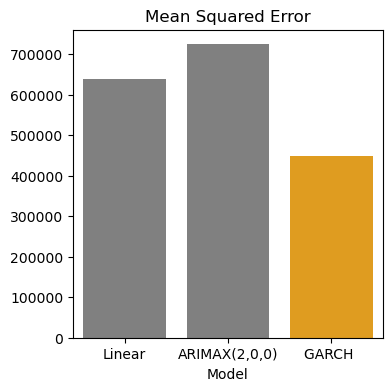

In [57]:
plt.figure(figsize=(4,4))
col = ['grey' if (x < max(accuracy_df[accuracy_df['accuracy'] == "MSE"])) else 'orange' for x in accuracy_df[accuracy_df['accuracy'] == "MSE"]]
ax = sns.barplot(accuracy_df[accuracy_df['accuracy'] == "MSE"],x="model", y="score",hue="model"\
            ,gap=0,palette=col).set(xlabel='Model', ylabel='')
plt.title('Mean Squared Error')
# saving the plot as an image
plt.savefig('../figure/Mean Squared Error.png')
plt.show()

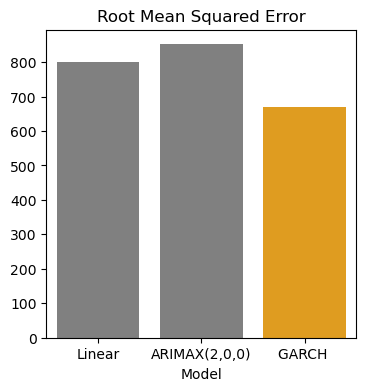

In [58]:
plt.figure(figsize=(4,4))
col = ['grey' if (x < max(accuracy_df[accuracy_df['accuracy'] == "RMSE"])) else 'orange' for x in accuracy_df[accuracy_df['accuracy'] == "RMSE"]]
ax = sns.barplot(accuracy_df[accuracy_df['accuracy'] == "RMSE"],x="model", y="score",hue="model"\
            ,gap=0,palette=col).set(xlabel='Model', ylabel='')
plt.title('Root Mean Squared Error')
# saving the plot as an image
plt.savefig('../figure/Root Mean Squared Error.png')
plt.show()

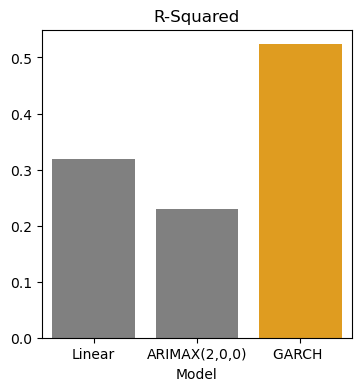

In [59]:
plt.figure(figsize=(4,4))
cols = ['grey' if (x < max(accuracy_df[accuracy_df['accuracy'] == "R2"])) else 'orange' for x in accuracy_df[accuracy_df['accuracy'] == "R2"]]
ax = sns.barplot(accuracy_df[accuracy_df['accuracy'] == "R2"],x="model", y="score",hue="model"\
            ,gap=0,palette=cols).set(xlabel='Model', ylabel='')
plt.title('R-Squared')
# saving the plot as an image
plt.savefig('../figure/R-Squared.png')
plt.show()